# Pricing of a Lookdown Put.

Authors : Ismaël BENDIB and François JORDAN

Our goal is to price the Lookback Put option whose payoff is $G := \bigg(\max\limits_{t\in[0,T]}\{X_t\}-X_T\bigg)^+=\max\bigg(\max\limits_{t\in[0,T]}\{X_t\}-X_T,0\bigg)$ in the Black-Scholes model with parameters $x_0 = 100, r = 0, \sigma = 0.4, T = 1$.

In [ ]:
# Importation of the necessary libraries

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import scipy.stats as sps
sqrt, exp = np.sqrt, np.exp
rng = default_rng(seed = 1)

In [ ]:
r, sigma, X0, T, n, m = 0, 0.4, 100, 1, 10**4, 100

# Function to simulate paths of the Black-Scholes process :

def BS_simulator(X0=100, sigma=0.4, r=0, T=1, m=100, n=10**4, W=None):
    if W is None:
      W = np.zeros([n,m+1])
      W[:,1::] = np.sqrt(T/m)*rng.normal(size = (n,m))
      W = np.cumsum(W,axis = 1)
    t = np.linspace(0,T,m+1)
    X = X0*np.exp(r*t+sigma* W)
    return X

## Two different Monte Carlo approaches

The Naive Monte Carlo estimator of $p$ is given by
$\overline{p}^{MC} = \lim\limits_{n\rightarrow +\infty}\frac{1}{n}\sum_{i=1}^n\bigg[e^{-rT}\bigg(\max\limits_{k = 0,\dots, m}\{X_{t_k}^i\}-X_T^i\bigg)^+\bigg]$

The Brownian Bridge Monte Carlo estimator of $p$ is given by
$\overline{p}^\text{BB} = \frac{1}{n} \sum_{i=1}^n\bigg[e^{-rT}\bigg(\max\limits_{k = 0,\dots, m}\{F^{-1}_m(U^{i}_k;X^i_{t_k},X^i_{t_{k+1}})\} - X^i_{t_m}\bigg)^+\bigg]$.

In [ ]:
# Naive Monte Carlo estimator
def MC(X0=100, sigma=0.4, r=0, T=1, m=100, n=10**4, W=None):
    if W is None:
      W = np.zeros([n,m+1])
      W[:,1::] = np.sqrt(T/m)*rng.normal(size = (n,m))
      W = np.cumsum(W,axis = 1)
    X = BS_simulator(X0, sigma, r, T, m, n, W) # Simulations of the n Black-Scholes paths of the underlying
    payoff_arr = np.max(X, axis=1) - X[:,-1] # Payoff of the option for each simulation
    estimator = np.mean(payoff_arr * exp(-r * T)) # Price estimator = discounted expectation of the payoff
    std_error = np.std(payoff_arr) / sqrt(n) # Standard error of the MC estimator
    return estimator, std_error

def MC_BB(X0=100, sigma=0.4, r=0, T=1, m=100, n=10**4, W=None, U=None):
  if W is None:
    W = np.zeros([n,m+1])
    W[:,1::] = np.sqrt(T/m)*rng.normal(size = (n,m))
    W = np.cumsum(W,axis = 1)
  X = BS_simulator(X0, sigma, r, T, m, n, W)
  if U is None:
    U = rng.uniform(size = (n,m))
  max_matrix = np.max(1/2*(X[:,:-1]+X[:,1::]+np.sqrt((X[:,1::]-X[:,:-1])**2-2*sigma**2*T/m*np.log(U))),axis = 1)
  estimator = np.maximum(max_matrix - X[:,-1],0).mean()
  std_error = np.maximum(max_matrix - X[:,-1],0).std() / sqrt(n)
  return estimator, std_error

In [ ]:
# Simulation of the random variables necessary for the first test

W = np.zeros([n,m+1])
W[:,1::] = np.sqrt(T/m)*rng.normal(size = (n,m))
W = np.cumsum(W,axis = 1)
U = rng.uniform(size = (n,m))

In [ ]:
estim, std_err = MC(W=W)
print("Estimated price with naive method : ", estim)
print("Confidence interval with naive method : [",estim-1.96*std_err, ";", estim+1.96*std_err,"].")

Estimated price with naive method :  30.66026138493305
Confidence interval with naive method : [ 30.258122586327257 ; 31.062400183538845 ].


In [ ]:
estim, std_err = MC_BB(W=W, U=U)
print("Estimated price with brownian bridge : ", estim)
print("Confidence interval with brownian bridge : [",estim-1.96*std_err, ";", estim+1.96*std_err,"].")

Estimated price with brownian bridge :  30.66101596747848
Confidence interval with brownian bridge : [ 30.25887749311051 ; 31.06315444184645 ].


As expected $\overline{p}^{MC} < \overline{p}^{BB}$.

## Comparison of the confidence intervals for Naive and Brownian Bridge methods for different values of $m$

In [ ]:
m_values = [10, 50, 100, 500, 1000]  # Time steps to test
# Running simulations for each m and collecting results
results = []

for m in m_values:
    W = np.zeros([n, m + 1])
    W[:, 1:] = np.sqrt(T/m) * rng.normal(size=(n, m))
    W = np.cumsum(W, axis=1)

    # Naive Monte Carlo
    estim_naive, std_err_naive = MC(X0, sigma, r, T, m, n, W)
    conf_int_naive = [estim_naive - 1.96 * std_err_naive, estim_naive + 1.96 * std_err_naive]

    # Monte Carlo with Brownian Bridge
    U = rng.uniform(size=(n, m))
    estim_bb, std_err_bb = MC_BB(X0, sigma, r, T, m, n, W, U)
    conf_int_bb = [estim_bb - 1.96 * std_err_bb, estim_bb + 1.96 * std_err_bb]

    # Append results
    results.append((m, conf_int_naive, conf_int_bb))

results

[(10,
  [68.85138988577286, 71.69086100970218],
  [68.85630559632287, 71.69575416287029]),
 (50,
  [90.37701871215754, 93.72479740114579],
  [90.37926849363042, 93.72703163295135]),
 (100,
  [94.48398202960911, 97.82591774406526],
  [94.48546496773675, 97.82739185072812]),
 (500,
  [104.57624866280156, 108.42109170573553],
  [104.57687897256324, 108.42171714685261]),
 (1000,
  [104.9449503163882, 109.03373917542697],
  [104.94537720748677, 109.03416294958161])]

## Behaviour of the Lookback Put against the Spot Price and the Volatility.

In [ ]:
# Values of X0 to consider
X0_values = np.linspace(0, 130, 300)

# Calculate the estimated price and standard error for each X0
estimates = []
std_errors = []
for element in X0_values:
    estim, std_err = MC_BB(X0=element)
    estimates.append(estim)
    std_errors.append(std_err)

# Calculate the upper and lower bounds of the 95% confidence interval
upper_bounds = [est + 1.96 * err for est, err in zip(estimates, std_errors)]
lower_bounds = [est - 1.96 * err for est, err in zip(estimates, std_errors)]

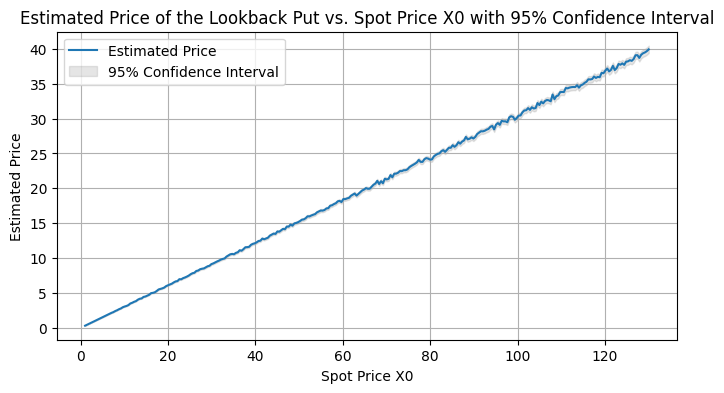

In [ ]:
# Plotting
plt.figure(figsize=(8, 4))
plt.plot(X0_values, estimates, label='Estimated Price')
plt.fill_between(X0_values, lower_bounds, upper_bounds, color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('Estimated Price of the Lookback Put vs. Spot Price X0 with 95% Confidence Interval')
plt.xlabel('Spot Price X0')
plt.ylabel('Estimated Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Values of sigma to consider
sigma_values = np.linspace(0.1, 0.6, 100)

# Calculate the estimated price for each sigma
estimates = []
std_errors = []
for element in sigma_values:
    estim, std_err = MC_BB(sigma=element)
    estimates.append(estim)
    std_errors.append(std_err)

# Calculate the upper and lower bounds of the 95% confidence interval
upper_bounds = [est + 1.96 * err for est, err in zip(estimates, std_errors)]
lower_bounds = [est - 1.96 * err for est, err in zip(estimates, std_errors)]

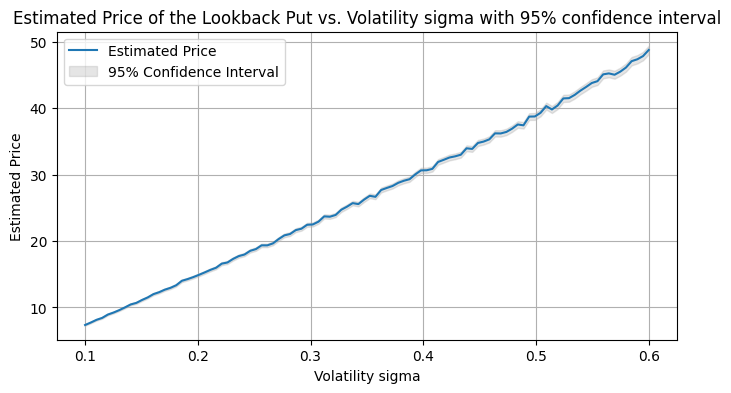

In [ ]:
# Plotting
plt.figure(figsize=(8, 4))
plt.plot(sigma_values, estimates, label='Estimated Price')
plt.fill_between(sigma_values, lower_bounds, upper_bounds, color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('Estimated Price of the Lookback Put vs. Volatility sigma with 95% confidence interval')
plt.xlabel('Volatility sigma')
plt.ylabel('Estimated Price')
plt.legend()
plt.grid(True)
plt.show()

# Estimation of the Delta of the option

The Delta $\Delta = \frac{\partial p}{\partial x}$ is the sensitivity of the price of the option w.r.t. the price of its underlying. I can be estimated by Monte Carlo and finite difference methods by :

$$\Delta \approx \frac{p(0,x_0+\epsilon) - p(0,x_0-\epsilon)}{2\epsilon} \approx \frac{\overline{p}^{BB}(0,x_0+\epsilon) - \overline{p}^{BB}(0,x_0-\epsilon)}{2\epsilon}$$

In [ ]:
def delta_BB(X0=100, sigma=0.4, r=0, T=1, m=100, n=10**4, h=0.1, W=None, U=None):
  if W is None:
    W = np.zeros([n,m+1])
    W[:,1::] = np.sqrt(T/m)*rng.normal(size = (n,m))
    W = np.cumsum(W,axis = 1)
    X_plus = BS_simulator(X0+h, sigma, r, T, m, n, W)
    X_minus = BS_simulator(X0-h, sigma, r, T, m, n, W)
  if U is None:
    U = rng.uniform(size = (n,m))
  max_matrix_plus = np.max(1/2*(X_plus[:,:-1]+X_plus[:,1::]+np.sqrt((X_plus[:,1::]-X_plus[:,:-1])**2-2*sigma**2*T/m*np.log(U))),axis = 1)
  max_matrix_minus = np.max(1/2*(X_minus[:,:-1]+X_minus[:,1::]+np.sqrt((X_minus[:,1::]-X_minus[:,:-1])**2-2*sigma**2*T/m*np.log(U))),axis = 1)
  estim_plus = np.maximum(max_matrix_plus - X_plus[:,-1],0).mean()
  estim_minus = np.maximum(max_matrix_minus - X_minus[:,-1],0).mean()

  return (estim_plus - estim_minus) / (2*h)

In [ ]:
W = np.zeros([n,m+1])
W[:,1::] = np.sqrt(T/m)*rng.normal(size = (n,m))
W = np.cumsum(W,axis = 1)
U = rng.uniform(size = (n,m))

In [ ]:
# Calculate the delta for each X0
X0_values = np.linspace(1, 130, 300)
delta_values = [delta_BB(X0=x) for x in X0_values]

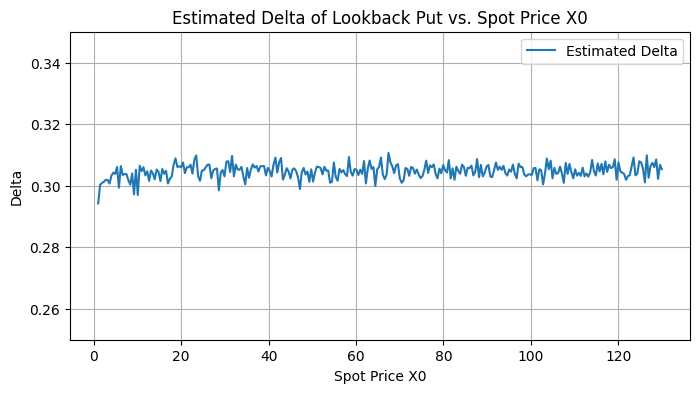

In [ ]:
# Plotting
plt.figure(figsize=(8, 4))
plt.plot(X0_values, delta_values, label='Estimated Delta')
plt.title('Estimated Delta of Lookback Put vs. Spot Price X0')
plt.ylim(0.25, 0.35)
plt.xlabel('Spot Price X0')
plt.ylabel('Delta')
plt.legend()
plt.grid(True)
plt.show()

# PDE Approach

We approximate $W^n$ recursively with the following relationship
\begin{equation}
  W^{n}= \mathcal{A}_\delta^{-1}(W^{n+1}-f_\delta^n)
\end{equation}
where
\begin{equation}
\mathcal{A}_\delta=
\begin{pmatrix}
        (1+rh+\frac{\sigma^2x_1^2h}{\delta^2})&(-\frac{rx_1h}{2\delta}-\frac{\sigma^2x_1^2h}{2\delta^2})&\cdots&\cdots&\cdots\\
        (\frac{rx_2h}{2\delta}-\frac{\sigma^2x_2^2h}{2\delta^2})&(1+rh+\frac{\sigma^2x_2^2h}{\delta^2})&(-\frac{rx_2h}{2\delta}-\frac{\sigma^2x_2^2h}{2\delta^2})&\cdots&\cdots\\
        \cdots&\ddots&\ddots&\ddots&\cdots\\
        \cdots&\cdots&(\frac{rx_{l-1}h}{2\delta}-\frac{\sigma^2x_{l-1}^2h}{2\delta^2})&(1+rh+\frac{\sigma^2x_{l-1}^2h}{\delta^2})&(-\frac{rx_{l-1}h}{2\delta}-\frac{\sigma^2x_{l-1}^2h}{2\delta^2})\\
        \cdots&\cdots&\cdots&(\frac{rx_{l}h}{2\delta}-\frac{\sigma^2x_{l}^2h}{2\delta^2})&(1+rh+\frac{\sigma^2x_{l}^2h}{\delta^2}+B)
    \end{pmatrix}
\end{equation}
and
\begin{equation}
  f_\delta^n =
  \begin{pmatrix}
    \Big(\frac{rx_1h}{2\delta}-\frac{\sigma^2x_1^2h}{2\delta^2}\Big)e^{-r(T-t_n)}\\
    0\\
    \vdots\\
    0
  \end{pmatrix}.
\end{equation}
We fix the parameters of the model as $ (\sigma,r,T,m,l)= (0.4,0,1,200,1000)$ and $X_0=100$.

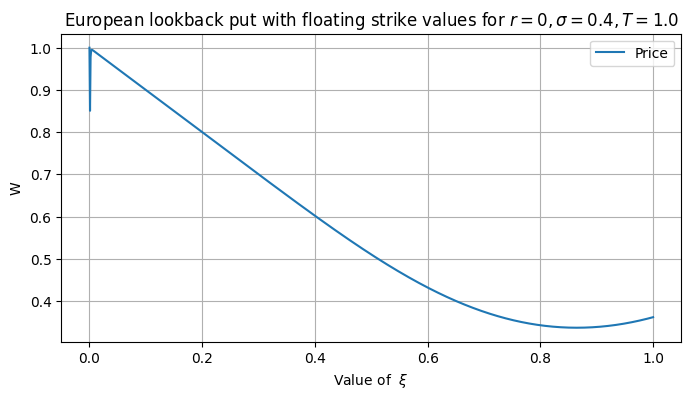

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv

m,l=200,1000
sigma,r,T=0.4,0,1.0
t = np.linspace(0,T,m+1)
x = np.linspace(0,1,l+2)

dt = T/m
dx = 1/(l+1)

u = np.zeros([l+2,m+1])
u[:,-1]=np.maximum(1-x,0)
u[0,:]=np.exp(-r*(T-t))
#matrix A
A = (1+r*dt+dt*(sigma*x[1:-1]/dx)**2)*np.eye(l)
A[1::,:-1]=A[1::,:-1]+(-dt*(sigma*x[2:-1]/dx)**2/2+r*x[2:-1]*dt/(2*dx))*np.eye(l-1)
A[:-1,1::]=A[:-1,1::]+(-dt*(sigma*x[1:-2]/dx)**2/2-r*x[1:-2]*dt/(2*dx))*np.eye(l-1)
A[-1,-1]=A[-1,-1]+(-dt*(sigma*x[-2]/dx)**2/2-r*x[-2]*dt/(2*dx))/(1-dx)

f = np.zeros([l,m+1])
f[0,:]=np.exp(-r*(T-t))*(r*x[1]*dt/(2*dx)-dt*(sigma*x[1]/dx)**2/2)

for i in range(m-1,-1,-1):
    u[1:-1,i]= inv(A)@(u[1:-1,i+1]+f[:,i])
    u[-1,i]= u[-2,i]/(1-dx)

plt.figure(figsize=(8, 4))
plt.plot(x,u[:,0], label='Price')
plt.title('European lookback put with floating strike values for $r=0,\sigma=0.4,T=1.0$')
plt.xlabel(r'Value of  $\xi$')
plt.ylabel('W')
plt.legend()
plt.grid(True)
plt.show()



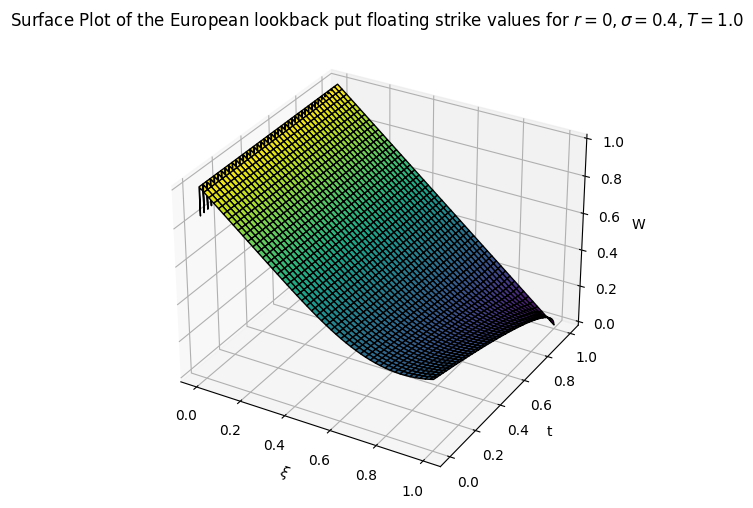

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Importing 3D toolkit

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid for 3D plot
X, T = np.meshgrid(x, t)

# Plot the surface
ax.plot_surface(X, T, u.T, cmap='viridis', edgecolor='k')

# Set labels and title
ax.set_xlabel(r'$\xi$')
ax.set_ylabel('t')
ax.set_zlabel('W')
ax.set_title('Surface Plot of the European lookback put floating strike values for $r=0,\sigma=0.4,T=1.0$')

# Show the plot
plt.show()
